Columns found: ['Date', 'Revenue']
Using date column: Date, target: Revenue, inferred freq: QE-OCT, seasonality: 4
Series length 29, train 22, test 7, horizon 7


C:\Users\Dell\anaconda3new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\Dell\anaconda3new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred fre

Model comparison (lower RMSE is better):
          model       MAE      RMSE   MAPE(%)  sMAPE(%)      MASE
0           ETS  0.360521  0.424667  4.240880  4.367510  0.684533
1  RandomForest  0.518071  0.572727  6.116971  6.351726  0.983680
2       SARIMAX  0.520256  0.587445  6.129245  6.375124  0.987828


C:\Users\Dell\anaconda3new\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-OCT will be used.
  self._init_dates(dates, freq)


Best model on test RMSE: ETS

Final ETS forecast (next 12 periods):
                mean  lower_95   upper_95
2025-10-31  8.748568  8.076227   9.420909
2026-01-31  8.881426  8.209084   9.553767
2026-04-30  9.045717  8.373376   9.718058
2026-07-31  8.840005  8.167664   9.512346
2026-10-31  8.898573  8.226232   9.570914
2027-01-31  9.031431  8.359089   9.703772
2027-04-30  9.195722  8.523381   9.868063
2027-07-31  8.990010  8.317669   9.662351
2027-10-31  9.048578  8.376237   9.720919
2028-01-31  9.181435  8.509094   9.853777
2028-04-30  9.345727  8.673386  10.018068
2028-07-31  9.140015  8.467673   9.812356


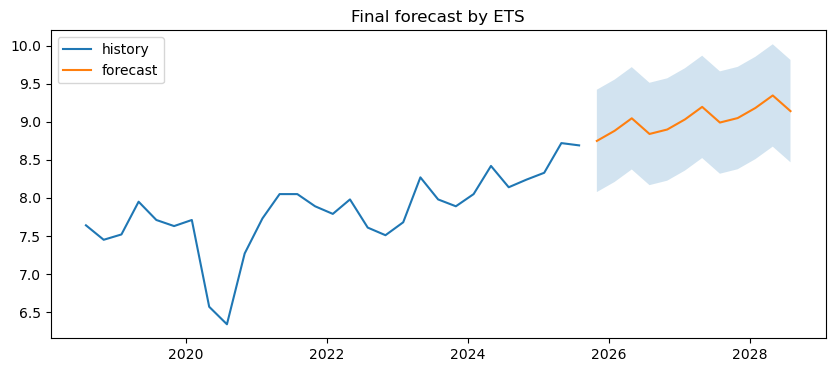

In [1]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt

def mase(y_true, y_pred, y_train, seasonality=1):
    if len(y_train) <= seasonality:
        denom = np.mean(np.abs(np.diff(y_train)))
    else:
        denom = np.mean(np.abs(y_train[seasonality:] - y_train[:-seasonality]))
    if denom == 0:
        return np.nan
    return np.mean(np.abs(y_true - y_pred)) / denom

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom[denom==0] = 1e-8
    return 100.0 * np.mean(np.abs(y_true - y_pred) / denom)

# loading datafile
path = "D:/revenue data.csv"

df = pd.read_csv(path)
print("Columns found:", df.columns.tolist())
# detect date column
date_col = None
for col in df.columns:
    parsed = pd.to_datetime(df[col], errors='coerce')
    if parsed.notna().sum() / len(parsed) > 0.6:
        date_col = col
        break
if date_col is None:
    date_col = df.columns[0]

# find numeric column (tries common revenue-like names)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) == 0:
    # try coercing non-date columns
    for col in df.columns:
        if col == date_col: continue
        coerced = pd.to_numeric(df[col], errors='coerce')
        if coerced.notna().sum() / len(coerced) > 0.6:
            df[col] = coerced
            numeric_cols.append(col)
if len(numeric_cols) == 0:
    raise ValueError("No numeric column found to forecast.")

candidates = [c for c in numeric_cols if any(k in c.lower() for k in ["rev","sales","value","amount","income","revenue"])]
target_col = candidates[0] if candidates else numeric_cols[0]

df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
ts = df[[date_col, target_col]].dropna().sort_values(date_col).set_index(date_col)
series = ts[target_col].astype(float)

inferred = pd.infer_freq(series.index)
if inferred is None:
    diffs = (series.index.to_series().diff().dropna()).median()
    if getattr(diffs, "days", None) and 27 <= diffs.days <= 31:
        inferred = 'M'
    elif getattr(diffs, "days", None) and diffs.days == 1:
        inferred = 'D'
    elif getattr(diffs, "days", None) and 6 <= diffs.days <= 8:
        inferred = 'W'
    else:
        inferred = 'D'
if 'M' in inferred:
    seasonality = 12
elif 'D' in inferred:
    seasonality = 7
elif 'W' in inferred:
    seasonality = 52
elif 'Q' in inferred:
    seasonality = 4
else:
    seasonality = 12

default_horizon = 12
horizon = min(default_horizon, int(len(series)//4)) if len(series) >= 24 else min(default_horizon, max(1, int(len(series)*0.25)))
if horizon < 1:
    horizon = min(default_horizon, len(series)//2)

train = series.iloc[:-horizon]
test = series.iloc[-horizon:]

print(f"Using date column: {date_col}, target: {target_col}, inferred freq: {inferred}, seasonality: {seasonality}")
print(f"Series length {len(series)}, train {len(train)}, test {len(test)}, horizon {horizon}")

# ETS
ets_pred_int = None
try:
    if len(train) >= seasonality*2:
        ets_model = ExponentialSmoothing(train, seasonal_periods=seasonality, trend='add', seasonal='add', initialization_method="estimated").fit(optimized=True)
    else:
        ets_model = ExponentialSmoothing(train, trend='add', seasonal=None, initialization_method="estimated").fit(optimized=True)
    ets_forecast = ets_model.forecast(horizon)
    resid = train - ets_model.fittedvalues
    se = resid.std(ddof=1)
    z = 1.96
    ets_pred_int = pd.DataFrame({'mean': ets_forecast, 'lower_95': ets_forecast - z*se, 'upper_95': ets_forecast + z*se})
except Exception as e:
    print("ETS error:", e)

# SARIMAX (small grid)
sarima_pred_int = None
try:
    best_aic = np.inf
    best_model = None
    for p in range(0,3):
        for d in range(0,2):
            for q in range(0,3):
                try:
                    m = SARIMAX(train, order=(p,d,q), seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                    if m.aic < best_aic:
                        best_aic = m.aic
                        best_model = m
                except Exception:
                    continue
    pred = best_model.get_forecast(steps=horizon)
    sarima_pred_int = pd.DataFrame({'mean': pred.predicted_mean, **pred.conf_int(alpha=0.05).to_dict(orient='list')})
    # conf_int columns may be named like lower y and upper y; adjust
    sarima_pred_int.columns = ['mean','lower_95','upper_95']
except Exception as e:
    print("SARIMAX error:", e)

# RandomForest with lags
rf_pred_int = None
try:
    max_lag = min(max(1, seasonality*2), 24)
    df_lags = pd.concat([series.shift(i) for i in range(1, max_lag+1)], axis=1)
    df_lags.columns = [f"lag_{i}" for i in range(1, max_lag+1)]
    df_rf = pd.concat([series, df_lags], axis=1).dropna()
    train_end = train.index[-1]
    rf_train = df_rf.loc[:train_end]
    X_train = rf_train.drop(columns=[target_col])
    y_train = rf_train[target_col]
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    preds = []
    preds_all_trees = []
    last_row = df_lags.loc[train.index[-1]].values.copy()
    for step in range(horizon):
        X_in = last_row.reshape(1,-1)
        tree_preds = np.array([est.predict(X_in)[0] for est in rf.estimators_])
        point = rf.predict(X_in)[0]
        preds.append(point)
        preds_all_trees.append(tree_preds)
        last_row = np.roll(last_row, 1); last_row[0] = point
    lower = [np.percentile(t, 2.5) for t in preds_all_trees]
    upper = [np.percentile(t, 97.5) for t in preds_all_trees]
    rf_pred_int = pd.DataFrame({'mean': preds, 'lower_95': lower, 'upper_95': upper}, index=test.index)
except Exception as e:
    print("RF error:", e)

# Compare
results = []
for name, dfm in [('ETS', ets_pred_int), ('SARIMAX', sarima_pred_int), ('RandomForest', rf_pred_int)]:
    if dfm is None:
        continue
    preds = np.array(dfm['mean'])[:len(test)]
    true = test.values[:len(preds)]
    mae = mean_absolute_error(true, preds)
    rmse = sqrt(mean_squared_error(true, preds))
    mape = np.mean(np.abs((true - preds) / (true + 1e-8))) * 100
    sm = smape(true, preds)
    ms = mase(true, preds, train.values, seasonality=seasonality)
    results.append({'model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE(%)': mape, 'sMAPE(%)': sm, 'MASE': ms})

results_df = pd.DataFrame(results).sort_values('RMSE').reset_index(drop=True)
print("Model comparison (lower RMSE is better):")
print(results_df)

# Refit best model on full series and forecast next 'default_horizon' periods
best = results_df.iloc[0]['model'] if not results_df.empty else None
final_horizon = default_horizon
final_index = pd.date_range(start=series.index[-1], periods=final_horizon+1, freq=inferred)[1:]
final_forecasts = {}

if best == 'ETS' and ets_pred_int is not None:
    if len(series) >= seasonality*2:
        final_ets = ExponentialSmoothing(series, seasonal_periods=seasonality, trend='add', seasonal='add', initialization_method="estimated").fit(optimized=True)
    else:
        final_ets = ExponentialSmoothing(series, trend='add', seasonal=None, initialization_method="estimated").fit(optimized=True)
    fcast = final_ets.forecast(final_horizon)
    resid = series - final_ets.fittedvalues
    se = resid.std(ddof=1)
    z = 1.96
    final_forecasts['ETS'] = pd.DataFrame({'mean': fcast, 'lower_95': fcast - z*se, 'upper_95': fcast + z*se}, index=final_index)

elif best == 'SARIMAX' and sarima_pred_int is not None:
    # small grid refit on full series
    best_aic = np.inf
    best_model_full = None
    for p in range(0,3):
        for d in range(0,2):
            for q in range(0,3):
                try:
                    m = SARIMAX(series, order=(p,d,q), seasonal_order=(0,0,0,0), enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
                    if m.aic < best_aic:
                        best_aic = m.aic
                        best_model_full = m
                except Exception:
                    continue
    pred = best_model_full.get_forecast(steps=final_horizon)
    final_forecasts['SARIMAX'] = pd.DataFrame({'mean': pred.predicted_mean, 'lower_95': pred.conf_int(alpha=0.05).iloc[:,0], 'upper_95': pred.conf_int(alpha=0.05).iloc[:,1]}, index=final_index)

elif best == 'RandomForest' and rf_pred_int is not None:
    max_lag = min(max(1, seasonality*2), 24)
    df_lags_full = pd.concat([series.shift(i) for i in range(1, max_lag+1)], axis=1)
    df_lags_full.columns = [f"lag_{i}" for i in range(1, max_lag+1)]
    df_rf_full = pd.concat([series, df_lags_full], axis=1).dropna()
    X_full = df_rf_full.drop(columns=[target_col])
    y_full = df_rf_full[target_col]
    rf_full = RandomForestRegressor(n_estimators=400, random_state=42)
    rf_full.fit(X_full, y_full)
    last_row = df_lags_full.loc[df_rf_full.index[-1]].values.copy()
    preds = []
    preds_all_trees = []
    for step in range(final_horizon):
        X_in = last_row.reshape(1,-1)
        tree_preds = np.array([est.predict(X_in)[0] for est in rf_full.estimators_])
        point = rf_full.predict(X_in)[0]
        preds.append(point)
        preds_all_trees.append(tree_preds)
        last_row = np.roll(last_row, 1); last_row[0] = point
    lower = [np.percentile(t,2.5) for t in preds_all_trees]
    upper = [np.percentile(t,97.5) for t in preds_all_trees]
    final_forecasts['RandomForest'] = pd.DataFrame({'mean': preds, 'lower_95': lower, 'upper_95': upper}, index=final_index)

print("Best model on test RMSE:", best)
for name, dfc in final_forecasts.items():
    print(f"\nFinal {name} forecast (next {final_horizon} periods):")
    print(dfc)
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values, label='history')
    plt.plot(dfc.index, dfc['mean'], label='forecast')
    plt.fill_between(dfc.index, dfc['lower_95'], dfc['upper_95'], alpha=0.2)
    plt.title(f"Final forecast by {name}")
    plt.legend()
    plt.show()


In [2]:
# ============================================================
# FULL COMPARISON: ARIMA vs SARIMA vs ARIMAX vs SARIMAX
# ============================================================

import os
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.diagnostic import acorr_ljungbox, normal_ad
from sklearn.metrics import mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------------------
# LOAD DATA
# ---------------------------------------------
FILE_PATH = "D:/revenue data.csv"

df = pd.read_csv(FILE_PATH)
df.columns = [c.strip() for c in df.columns]

date_col = df.columns[0]
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

df = df.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)
df = df.set_index(date_col)

# numeric target variable
target_col = df.select_dtypes(include=[np.number]).columns[0]
ts = df[target_col].astype(float)

# force quarterly frequency
ts.index = pd.date_range(start=ts.index.min(), periods=len(ts), freq="Q")

# ---------------------------------------------
# EXOGENOUS VARIABLES (MoM, YoY)
# ---------------------------------------------
exog = pd.DataFrame(index=ts.index)
exog["MoM"] = ts.pct_change(1) * 100
exog["YoY"] = ts.pct_change(4) * 100
exog = exog.dropna()

# match target series
ts = ts.loc[exog.index]

# ---------------------------------------------
# TRAIN / TEST SPLIT (80/20)
# ---------------------------------------------
N = len(ts)
train_size = int(N * 0.8)

train_y = ts.iloc[:train_size]
test_y = ts.iloc[train_size:]

train_exog = exog.iloc[:train_size]
test_exog = exog.iloc[train_size:]

# ---------------------------------------------
# Helper function to fit and evaluate models
# ---------------------------------------------
def evaluate_model(name, order, seasonal_order, use_exog=False):
    try:
        if use_exog:
            model = SARIMAX(train_y, exog=train_exog, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False)

            pred = res.get_forecast(steps=len(test_y), exog=test_exog).predicted_mean
        else:
            model = SARIMAX(train_y, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False)

            pred = res.get_forecast(steps=len(test_y)).predicted_mean

        # evaluation metrics
        model_rmse = rmse(test_y, pred)
        model_mape = mean_absolute_percentage_error(test_y, pred) * 100

        # residual tests
        resid = res.resid
        lb = acorr_ljungbox(resid, lags=[10], return_df=True)
        lb_p = lb["lb_pvalue"].iloc[0]

        jb_p = normal_ad(resid)[1]  # normality p-value

        return {
            "Model": name,
            "AIC": res.aic,
            "BIC": res.bic,
            "RMSE": model_rmse,
            "MAPE%": model_mape,
            "LjungBox p": lb_p,
            "Normality p": jb_p,
        }

    except Exception as e:
        return {
            "Model": name,
            "AIC": None,
            "BIC": None,
            "RMSE": None,
            "MAPE%": None,
            "LjungBox p": None,
            "Normality p": None,
        }

# ---------------------------------------------
# MODEL DEFINITIONS
# ---------------------------------------------

results = []

# 1) ARIMA (no seasonality, no exog)
results.append(evaluate_model(
    "ARIMA",
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    use_exog=False
))

# 2) SARIMA (seasonality, no exog)
results.append(evaluate_model(
    "SARIMA",
    order=(1,1,1),
    seasonal_order=(1,1,1,4),
    use_exog=False
))

# 3) ARIMAX (exogenous MoM + YoY)
results.append(evaluate_model(
    "ARIMAX",
    order=(1,1,1),
    seasonal_order=(0,0,0,0),
    use_exog=True
))

# 4) SARIMAX (seasonality + exogenous)
results.append(evaluate_model(
    "SARIMAX",
    order=(1,1,1),
    seasonal_order=(1,1,1,4),
    use_exog=True
))

# ---------------------------------------------
# RESULTS TABLE
# ---------------------------------------------
results_df = pd.DataFrame(results)
print("\n================ MODEL COMPARISON ================\n")
print(results_df.to_string(index=False))

# Save comparison locally
out_path = "model_comparison.csv"
results_df.to_csv(out_path, index=False)
print(f"\nResults saved to {out_path}")




================ MODEL COMPARISON ================

  Model       AIC       BIC     RMSE    MAPE%  LjungBox p  Normality p
  ARIMA 24.919263 27.418903 0.258024 2.936116    0.998670 5.248730e-10
 SARIMA  7.018876  8.004999 0.213846 1.982600    0.426227 1.673189e-04
 ARIMAX  5.725368  9.891435 0.212376 2.308320    0.999995 2.802082e-13
SARIMAX -3.022091 -1.641519 0.213232 2.264687    0.715399 7.416418e-08

Results saved to model_comparison.csv


In [12]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Load your data from the CSV file
data_path = 'D:/revenue data.csv'
revenue_data = pd.read_csv(data_path)

# --- CRITICAL STEP: Prepare the DataFrame for time series modeling ---
# Replace 'Your_Date_Column_Name' with the actual name of your date/timestamp column in the CSV
date_column_name = 'Date' 

# Replace 'Your_Value_Column_Name' with the actual name of the column containing the values you want to forecast (e.g., 'revenue')
value_column_name = 'Revenue'

# Convert the date column to actual datetime objects and set it as the index
revenue_data[date_column_name] = pd.to_datetime(revenue_data[date_column_name])
revenue_data.set_index(date_column_name, inplace=True)

# 2. Re-fit the SARIMAX model
# Ensure 'order' and 'seasonal_order' match the parameters of your *best* model identified earlier.
try:
    model = sm.tsa.SARIMAX(revenue_data[value_column_name], 
                            order=(1, 1, 1), 
                            seasonal_order=(1, 0, 0, 12),
                            enforce_stationarity=False,
                            enforce_invertibility=False)
    
    fitted_sarimax_model = model.fit(disp=False) # disp=False prevents excessive output during fitting

    print("Model fitting complete.")

    # 3. Generate forecasts using the newly fitted model
    forecast_results = fitted_sarimax_model.get_forecast(steps=10)
    predictions = forecast_results.predicted_mean
    confidence_intervals = forecast_results.conf_int(alpha=0.05)
    
    print("\nPredictions (Forecasted Mean):")
    print(predictions)
    print("\nConfidence Intervals (95% CI):")
    print(confidence_intervals)

except KeyError as e:
    print(f"\nError: Missing column name. Please check your column names in the CSV file.")
    print(f"Verify that '{date_column_name}' and '{value_column_name}' exist.")
except Exception as e:
    print(f"\nAn error occurred during model fitting: {e}")



Model fitting complete.

Predictions (Forecasted Mean):
2025-10-31    8.660101
2026-01-31    8.639704
2026-04-30    8.587023
2026-07-31    8.612434
2026-10-31    8.620339
2027-01-31    8.606257
2027-04-30    8.573699
2027-07-31    8.598337
2027-10-31    8.589538
2028-01-31    8.581618
Freq: QE-OCT, Name: predicted_mean, dtype: float64

Confidence Intervals (95% CI):
            lower Revenue  upper Revenue
2025-10-31       8.163145       9.157057
2026-01-31       8.030692       9.248717
2026-04-30       7.893549       9.280496
2026-07-31       7.844955       9.379913
2026-10-31       7.785546       9.455131
2027-01-31       7.709208       9.503306
2027-04-30       7.618445       9.528952
2027-07-31       7.588228       9.608447
2027-10-31       7.527402       9.651674
2028-01-31       7.469888       9.693348
